In [ ]:
import cv2
import os
import numpy
from PIL import Image

In [ ]:
label_list = ['0','1','2','3','4','5','6','7','8','9', 'A','B','C','D','E','F','G','H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [ ]:
transform = transforms.Compose(
    [
    #  transforms.ToPILImage(),
    #  transforms.Grayscale(num_output_channels=1),
    #  transforms.Resize((28,28)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5), (0.5)),
     ]
)

def load_dataset_t():
  data_path = './Hnd/'
  # train_dataset = datasets.ImageFolder(
  #     root=data_path,
  #     transform=transform
  # )
  train_dataset = datasets.EMNIST(root=  "./data",split="byclass", train = True, download = False, transform = transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=128,
      num_workers=2,
      shuffle=True
  )
  return train_loader

def load_dataset_ts():
  data_path = './Hnd/'
  # train_dataset = datasets.ImageFolder(
  #     root=data_path,
  #     transform=transform
  # )
  test_dataset = datasets.EMNIST(root=  "./data",split="byclass", train = False, download = False, transform = transform)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=64,
      num_workers=2,
      shuffle=True
  )
  return test_loader

In [ ]:
# load_dataset()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
dataiter = iter(load_dataset_t())
images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    # print(labels[index])


In [ ]:
device

In [ ]:
import torch.nn.functional as F


In [ ]:
# defining the model architecture
class Net(torch.nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = torch.nn.Sequential(
          # Defining a 2D convolution layer
          torch.nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          torch.nn.BatchNorm2d(4),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          torch.nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          torch.nn.BatchNorm2d(4),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = torch.nn.Sequential(
          torch.nn.Linear(4 * 7 * 7, 62)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      # print(x.size)
      x = self.linear_layers(x)
      return x

In [ ]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05,
                      momentum=0.5)
cc = torch.nn.CrossEntropyLoss()

model.cuda()
cc = cc.cuda()

In [ ]:
model

In [ ]:
for i in range(30):
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(load_dataset_t()):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = cc(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(load_dataset_t())))


In [ ]:
torch.save(model, './model_character_detect.pt')

In [ ]:
mm = torch.load('./model_character_detect.pt')

In [28]:
total = 0
mm.eval()
correct = 0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(load_dataset_ts()):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = mm(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


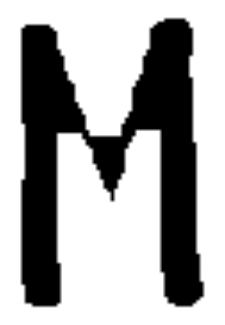

In [39]:
image = Image.open("../Images/segmentation2/image_2_ROI_1.png")
image


In [40]:
transform = transforms.Compose(
    [
    #  transforms.ToPILImage(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Resize((28,28)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5), (0.5)),
     ]
)


In [41]:
image = transform(image)
image = image.cuda()

In [ ]:
mm


In [42]:
# image = image.cuda()
lp = mm(image[None, ...])

In [43]:
ps = torch.exp(lp)
probab = list(ps.cpu()[0])
pred_label = probab.index(max(probab))

In [44]:
lp

tensor([[  9.7822,  -9.2660,   1.0041,   1.2574, -21.2339,   7.8191,  -0.9486,
          -7.9979,  10.4634,   4.2336,   3.9629,  15.7870,   3.9940,  20.1944,
           4.2583,  -0.2584,   9.0266, -22.9915,  10.7060,  12.0631,  -7.8693,
          -7.6812,  -7.0087,  -1.4249,  12.9591,   0.8182,  12.7905,  12.0966,
           3.2855,   0.1476,  -2.2615,  -8.1726,  -0.6786,  -6.0806,  -7.1914,
           7.6328,  10.1098,  -3.2158,  -2.4524,  -4.4376,   3.5000,  -2.5345,
          11.0136,  -9.6387,  -5.5496,  -3.6103,  -7.7525,  -3.5272,  -5.7489,
          -1.1082,   7.4813,   1.3978,   9.5256,  -5.7517,   1.1410, -12.7823,
          -7.5822,  -8.7728,  -2.8349,  -7.7433,  -9.6235,   1.7765]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [35]:
max(probab)

tensor(1.6476e+29, grad_fn=<UnbindBackward>)

In [45]:
label_list[pred_label]

'D'